<a href="https://colab.research.google.com/github/RE-NY/Assignment_1_feynn_labs/blob/main/assignment1_feynn_labs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d daggysheep/find-a-car-park

100% 5.00G/5.00G [02:11<00:00, 38.5MB/s]
100% 5.00G/5.00G [02:11<00:00, 40.9MB/s]


In [ ]:
! unzip "/content/find-a-car-park.zip" -d "/content/dataset/"

In [6]:
import pandas as pd
import numpy as np
import cv2
import os

In [7]:
data_path = "/content/dataset/data"
Categories = ["Free", "Full"]
img_size = 150

data = []

def create_data():
    for category in Categories:
        path = os.path.join(data_path,category)
        class_num = Categories.index(category)
        print(path) #lepath to each category file
        for img in os.listdir(path):
            #print(img) #path to each image in the category files
            img_arr = cv2.imread(os.path.join(path,img))
            new_img_arr = cv2.resize(img_arr,(img_size,img_size))
            data.append([new_img_arr,class_num])
create_data()


/content/dataset/data/Free
/content/dataset/data/Full


In [8]:
X= [] #store images
Y= [] #store lables["free","full"]

for features, labels in data:
    X.append(features)
    Y.append(labels)

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [10]:
import tensorflow as tf
def process_images(image):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image

x_train = process_images(x_train)
x_test = process_images(x_test)

x_train = np.array(x_train).reshape(-1, 227, 227, 3)
y_train = np.array(y_train)
x_test = np.array(x_test).reshape(-1, 227, 227, 3)
y_test = np.array(y_test)

x_validate = x_train[:520]
x_train = x_train[521:]
y_validate = y_train[:520]
y_train = y_train[521:]

### Exploratory Data Analysis(EDA) on the dataset

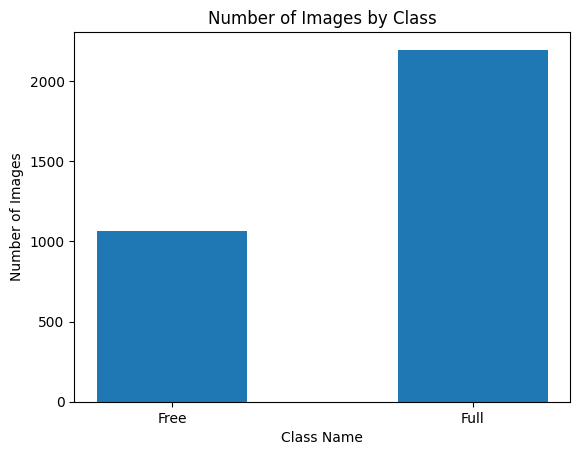

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

number_classes = {
    "Free" : len(os.listdir("/content/dataset/data/Free")),
    "Full" : len(os.listdir("/content/dataset/data/Full"))
}

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('Number of Images');

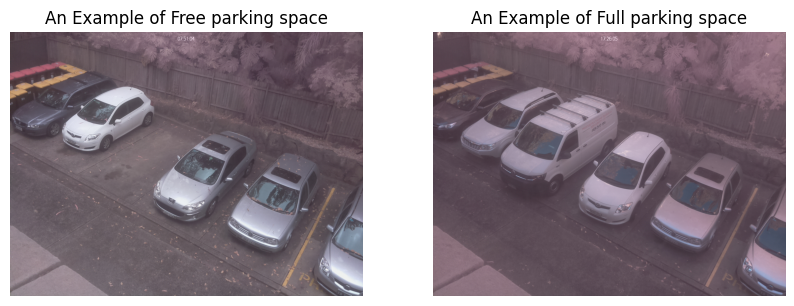

In [12]:
img1 = mpimg.imread("/content/dataset/data/Free/img_1006075057.jpg")
img2 = mpimg.imread("/content/dataset/data/Full/img_1001172558.jpg")

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image on the first subplot
axs[0].imshow(img1)
axs[0].axis('off')  # Optional: Turn off axis labels

# Display the second image on the second subplot
axs[1].imshow(img2)
axs[1].axis('off')  # Optional: Turn off axis labels

# Add titles if needed
axs[0].set_title('An Example of Free parking space')
axs[1].set_title('An Example of Full parking space')

plt.show()

### Making the model and Evaluating
Importing a VGG19 network and evaluating the results

In [13]:

from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19

# Download the pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add your custom top layers for classification
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Adjust num_classes according to your dataset

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 20124745 (76.77 MB)
Trainable params: 100361 (392.04 KB)
Non-trainable params: 20024384 (76.39 MB)
__________

In [14]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 5,restore_best_weights = True)

# fit the model
history = model.fit(x_train,y_train, epochs=25, validation_data = (x_validate,y_validate),callbacks =[earlystopping])

model.evaluate(x_test, y_test)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


66/66 [==============================] - 32s 327ms/step - loss: 0.0000e+00 - accuracy: 0.3247 - val_loss: 0.0000e+00 - val_accuracy: 0.3019
Epoch 2/25
66/66 [==============================] - 14s 212ms/step - loss: 0.0000e+00 - accuracy: 0.3199 - val_loss: 0.0000e+00 - val_accuracy: 0.3019
Epoch 3/25
66/66 [==============================] - 14s 220ms/step - loss: 0.0000e+00 - accuracy: 0.3199 - val_loss: 0.0000e+00 - val_accuracy: 0.3019
Epoch 4/25
66/66 [==============================] - 17s 253ms/step - loss: 0.0000e+00 - accuracy: 0.3199 - val_loss: 0.0000e+00 - val_accuracy: 0.3019
Epoch 5/25
66/66 [==============================] - 16s 248ms/step - loss: 0.0000e+00 - accuracy: 0.3199 - val_loss: 0.0000e+00 - val_accuracy: 0.3019
Epoch 6/25
21/21 [==============================] - 7s 344ms/step - loss: 0.0000e+00 - accuracy: 0.3706


[0.0, 0.370597243309021]